### This Model classifies the images into two classes:(8QAM and 16QAM) and (32QAM and 64QAM)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.preprocessing import image

In [2]:
data_dir='dataset/train'

In [3]:
test_data_dir='dataset/test'

In [4]:
classes=[str(i) for i in range(6)]

In [5]:
val_data_dir='dataset/valid'

In [6]:
train_images_per_class=500

In [7]:
def gen_circle(img: np.ndarray, center: tuple, diameter: int,fill_val: int) -> np.ndarray:
  
    """
        Creates a matrix of ones filling a circle.
    """

    # gets the radius of the image
    radius  = diameter//2

    # gets the row and column center of the image
    row, col = center 

    # generates theta vector to variate the angle
    theta = np.arange(0, 360)*(np.pi/180)

    # generates the indexes of the column
    y = (radius*np.sin(theta)).astype("int32") 

    # generates the indexes of the rows
    x = (radius*np.cos(theta)).astype("int32") 

    # with:
    # img[x, y] = 1
    # you can draw the border of the circle 
    # instead of the inner part and the border. 

    # centers the circle at the input center
    rows = x + (row)
    cols  = y + (col)

    # gets the number of rows and columns to make 
    # to cut by half the execution
    nrows = rows.shape[0] 
    ncols = cols.shape[0]

    # makes a copy of the image
    img_copy = np.copy(img)

    # We use the simetry in our favour
    # does reflection on the horizontal axes 
    # and in the vertical axes

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                            np.flip(rows[nrows//4:nrows//2]),
                            cols[:ncols//4],
                            cols[nrows//2:3*ncols//4]):
    
        img_copy[row_up:row_down, col2:col1] = fill_val

 
    return img_copy

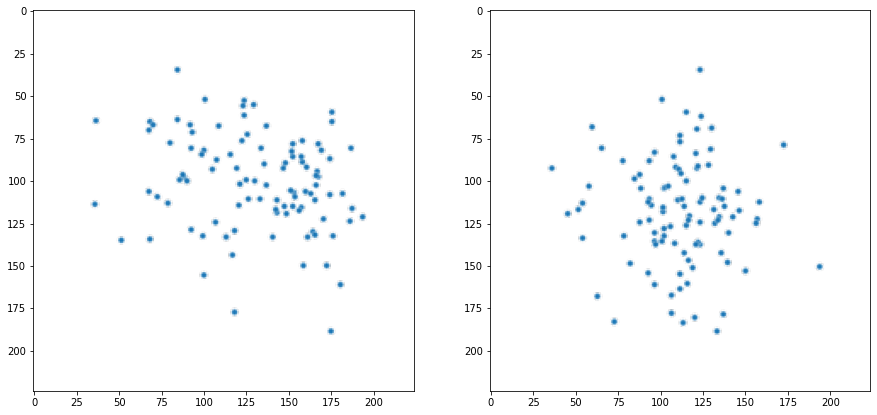

In [8]:
from matplotlib import pyplot as plt
from PIL import Image
 
# Opens a image in RGB mode
newsize=(224,224)

sample_imgs=[19,8]
imgs=[]
for i in range(2,4):
  imgs.append(Image.open("dataset/train/"+str(i)+'/'+str(sample_imgs[i-2])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 1
columns = 2


for i in range(2):
  # Adds a subplot at the ith position
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(imgs[i])

  
# showing image

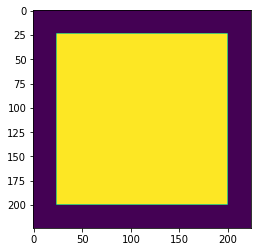

In [9]:
# R filter
#Square

r_filter_dim=(24,200)
fil=np.zeros((224,224),dtype=int)
for i in range(r_filter_dim[0],r_filter_dim[1]):
  for j in range(r_filter_dim[0],r_filter_dim[1]):
    fil[i][j]=1
plt.imshow(fil)

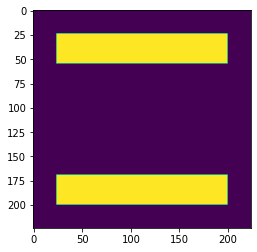

In [10]:
# G filter

# two rectangles
g_filter_dim=[[24,55],[224-55,200],[24,200]]
fil=np.zeros((224,224),dtype=int)
#1st rectangle
for i in range(g_filter_dim[0][0],g_filter_dim[0][1]):
  for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
    fil[i][j]=1
#2nd rectangle 
for i in range(g_filter_dim[1][0],g_filter_dim[1][1]):
  for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
    fil[i][j]=1
plt.imshow(fil)

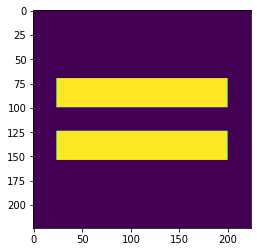

In [11]:
# B filter

# two rectangles
b_filter_dim=[[70,100],[224-100,224-70],[24,200]]
fil=np.zeros((224,224),dtype=int)
#1st rectangle
for i in range(b_filter_dim[0][0],b_filter_dim[0][1]):
  for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
    fil[i][j]=1
#2nd rectangle 
for i in range(b_filter_dim[1][0],b_filter_dim[1][1]):
  for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
    fil[i][j]=1
plt.imshow(fil)

In [12]:
def apply_filter(im):
  center = (112,112)

  #red layer filter 
  r_filter_dim=(24,200)
  fil=np.zeros((224,224),dtype=int)
  for i in range(r_filter_dim[0],r_filter_dim[1]):
    for j in range(r_filter_dim[0],r_filter_dim[1]):
      fil[i][j]=1
  im[:,:,0]=im[:,:,0]*fil


  #green layer filter
  g_filter_dim=[[24,55],[224-55,200],[24,200]]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(g_filter_dim[0][0],g_filter_dim[0][1]):
    for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
      fil[i][j]=1
  #2nd rectangle 
  for i in range(g_filter_dim[1][0],g_filter_dim[1][1]):
    for j in range(g_filter_dim[2][0],g_filter_dim[2][1]):
      fil[i][j]=1
  im[:,:,1]=im[:,:,1]*fil


  #blue layer filter
  b_filter_dim=[[70,100],[224-100,224-70],[24,200]]
  fil=np.zeros((224,224),dtype=int)
  #1st rectangle
  for i in range(b_filter_dim[0][0],b_filter_dim[0][1]):
    for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
      fil[i][j]=1
  #2nd rectangle 
  for i in range(b_filter_dim[1][0],b_filter_dim[1][1]):
    for j in range(b_filter_dim[2][0],b_filter_dim[2][1]):
      fil[i][j]=1
  im[:,:,2]=im[:,:,2]*fil
  
  return im

In [13]:
def disp_filter_image(im):
  im=apply_filter(im)
  plt.imshow(im)
  plt.axis('off')

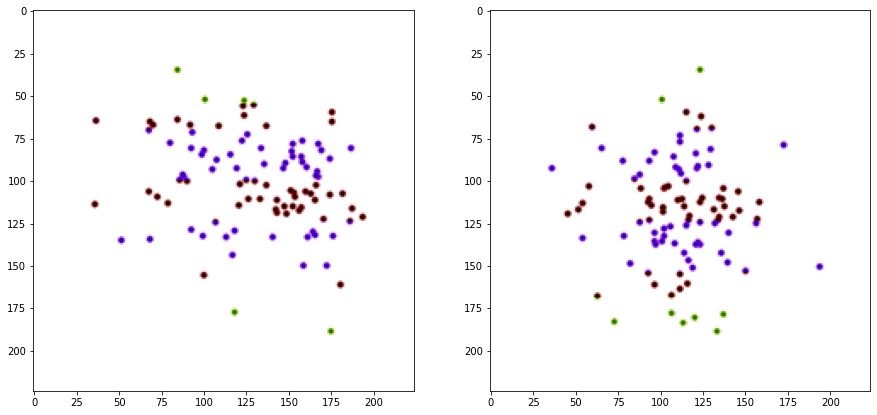

In [14]:
fil_imgs=[]
for i in range(2):
  fil_imgs.append(Image.open("dataset/train/"+str(i+2)+'/'+str(sample_imgs[i])+".png").resize(newsize))
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 1
columns = 2

for i in range(2):
  # Adds a subplot at the ith position
  fil_imgs[i]=apply_filter(np.array(fil_imgs[i]))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(fil_imgs[i])

In [15]:
train_data=[]
train_label=[]
img_height,img_width=224,224
for cls in classes[2:4]:
  print(cls)
  for i in range(500):
    img_path=data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(img)
    train_data.append(img_data)
    train_label.append(int(cls))

2
3


In [16]:
train_label[:train_images_per_class]=[0]*train_images_per_class
train_label[train_images_per_class:]=[1]*train_images_per_class

In [17]:
valid_images_per_class=100

In [18]:
valid_data=[]
valid_label=[]
img_height,img_width=224,224
for cls in classes[2:4]:
  print(cls)
  for i in range(100):
    img_path=val_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(img)
    valid_data.append(img_data)
    valid_label.append(int(cls))


2
3


In [19]:
valid_label=[]
valid_label[:valid_images_per_class]=[0]*valid_images_per_class
valid_label[valid_images_per_class:]=[1]*valid_images_per_class

In [20]:
train_data=np.asarray(train_data)
train_label=np.asarray(train_label)

In [21]:
valid_data=np.asarray(valid_data)
valid_label=np.asarray(valid_label)

In [22]:
for i in range(len(train_label)):
  train_data[i]=apply_filter(train_data[i])

In [23]:
for i in range(len(valid_label)):
  valid_data[i]=apply_filter(valid_data[i])

In [24]:
def preprocess_data(X,Y,n):
  X_p=preprocess_input(X)
  Y_p=tf.keras.utils.to_categorical(Y,n)
  return (X_p,Y_p)

In [25]:
train_data,train_label=preprocess_data(train_data,train_label,2)

In [26]:
valid_data,valid_label=preprocess_data(valid_data,valid_label,2)

In [27]:
print(train_data.shape,train_label.shape)

(1000, 224, 224, 3) (1000, 2)


In [28]:
resnet_model = Sequential()
input_t=tf.keras.Input(shape=(224,224,3))
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_tensor=input_t,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [29]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [30]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_data,train_label, validation_data=(valid_data,valid_label),batch_size=32, epochs=25,verbose=1)

c:\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
32/32 [==============================] - 81s 2s/step - loss: 4.5636 - accuracy: 0.6490 - val_loss: 0.3469 - val_accuracy: 0.8500
Epoch 2/25
32/32 [==============================] - 74s 2s/step - loss: 0.6562 - accuracy: 0.7690 - val_loss: 0.4781 - val_accuracy: 0.8450
Epoch 3/25
32/32 [==============================] - 80s 3s/step - loss: 0.3745 - accuracy: 0.8180 - val_loss: 0.2618 - val_accuracy: 0.8750
Epoch 4/25
32/32 [==============================] - 76s 2s/step - loss: 0.3555 - accuracy: 0.8270 - val_loss: 0.3122 - val_accuracy: 0.8650
Epoch 5/25
32/32 [==============================] - 75s 2s/step - loss: 0.3530 - accuracy: 0.8270 - val_loss: 0.3982 - val_accuracy: 0.8300
Epoch 6/25
21/32 [==================>...........] - ETA: 23s - loss: 0.3463 - accuracy: 0.8318

KeyboardInterrupt: 

In [33]:
test_images_per_class=150

In [34]:
test_data=[]
test_label=[]
img_height,img_width=224,224
for cls in classes[2:4]:
  print(cls)
  for i in range(test_images_per_class):
    img_path=test_data_dir+'/'+cls+'/'+str(i)+'.png'
    img=image.load_img(img_path,target_size=(img_height,img_width))
    img_data=np.asarray(img)
    test_data.append(img_data)
    test_label.append(int(cls))

2
3


In [35]:
test_label=[]
test_label[:test_images_per_class]=[0]*test_images_per_class
test_label[test_images_per_class:]=[1]*test_images_per_class

In [36]:
test_data=np.asarray(test_data)
test_label=np.asarray(test_label)

In [37]:
for i in range(len(test_label)):
  test_data[i]=apply_filter(test_data[i])

In [38]:
test_data,test_label=preprocess_data(test_data,test_label,2)

In [39]:
test_data.shape,test_label.shape

((300, 224, 224, 3), (300, 2))

In [40]:
test_loss,test_acc=resnet_model.evaluate(test_data,test_label,verbose=1)

10/10 [==============================] - 34s 3s/step - loss: 0.5872 - accuracy: 0.7833


In [41]:
print('Testing data accuracy = '+str(test_acc)+'\n Testing data loss = '+str(test_loss))

Testing data accuracy = 0.7833333611488342
 Testing data loss = 0.5872239470481873


In [43]:
from tensorflow.keras.models import model_from_json

In [44]:
model_json = resnet_model.to_json()
with open("Models/filter_model_4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet_model.save_weights("Models/filter_model_4.h5")
print("Saved model to disk")
 

c:\python\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk
